In [1]:
# License: BSD
# Author: Sasank Chilamkurthy

import torch
import torch.nn as nn
import torch.optim as optim
from torch.optim import lr_scheduler
import torch.backends.cudnn as cudnn
import numpy as np
import torchvision
from torchvision import datasets, models, transforms
import matplotlib.pyplot as plt
import time
import os
from PIL import Image
from tempfile import TemporaryDirectory

cudnn.benchmark = True
plt.ion()   # interactive mode

In [2]:
# Data augmentation and normalization for training
# Just normalization for validation
data_transforms = {
    'train': transforms.Compose([
        transforms.RandomResizedCrop(224),
        transforms.RandomHorizontalFlip(),
        transforms.ToTensor(),
        transforms.Normalize([0.485, 0.456, 0.406], [0.229, 0.224, 0.225])
    ]),
    'test': transforms.Compose([
        transforms.Resize(256),
        transforms.CenterCrop(224),
        transforms.ToTensor(),
        transforms.Normalize([0.485, 0.456, 0.406], [0.229, 0.224, 0.225])
    ]),
}

data_dir = '/kaggle/input/potholehumpvgg/customdataset'
image_datasets = {x: datasets.ImageFolder(os.path.join(data_dir, x),
                                          data_transforms[x])
                  for x in ['train', 'test']}
dataloaders = {x: torch.utils.data.DataLoader(image_datasets[x], batch_size=4,
                                             shuffle=True, num_workers=4)
              for x in ['train', 'test']}
dataset_sizes = {x: len(image_datasets[x]) for x in ['train', 'test']}
class_names = image_datasets['train'].classes

device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")



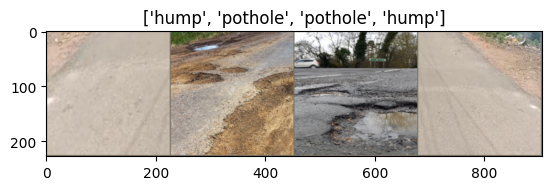

In [3]:
def imshow(inp, title=None):
    """Display image for Tensor."""
    inp = inp.numpy().transpose((1, 2, 0))
    mean = np.array([0.485, 0.456, 0.406])
    std = np.array([0.229, 0.224, 0.225])
    inp = std * inp + mean
    inp = np.clip(inp, 0, 1)
    plt.imshow(inp)
    if title is not None:
        plt.title(title)
    plt.pause(0.001)  # pause a bit so that plots are updated


# Get a batch of training data
inputs, classes = next(iter(dataloaders['train']))

# Make a grid from batch
out = torchvision.utils.make_grid(inputs)

imshow(out, title=[class_names[x] for x in classes])

In [4]:
def train_model(model, criterion, optimizer, num_epochs=25):
    since = time.time()

    # Create a temporary directory to save training checkpoints
    with TemporaryDirectory() as tempdir:
        best_model_params_path = os.path.join(tempdir, 'best_model_params.pt')

        torch.save(model.state_dict(), best_model_params_path)
        best_acc = 0.0

        for epoch in range(num_epochs):
            print(f'Epoch {epoch}/{num_epochs - 1}')
            print('-' * 10)

            # Each epoch has a training and validation phase
            for phase in ['train', 'test']:
                if phase == 'train':
                    model.train()  # Set model to training mode
                else:
                    model.eval()   # Set model to evaluate mode

                running_loss = 0.0
                running_corrects = 0

                # Iterate over data.
                for inputs, labels in dataloaders[phase]:
                    inputs = inputs.to(device)
                    labels = labels.to(device)

                    # zero the parameter gradients
                    optimizer.zero_grad()

                    # forward
                    # track history if only in train
                    with torch.set_grad_enabled(phase == 'train'):
                        outputs = model(inputs)
                        _, preds = torch.max(outputs, 1)
                        loss = criterion(outputs, labels)

                        # backward + optimize only if in training phase
                        if phase == 'train':
                            loss.backward()
                            optimizer.step()

                    # statistics
                    running_loss += loss.item() * inputs.size(0)
                    running_corrects += torch.sum(preds == labels.data)
                

                epoch_loss = running_loss / dataset_sizes[phase]
                epoch_acc = running_corrects.double() / dataset_sizes[phase]

                print(f'{phase} Loss: {epoch_loss:.4f} Acc: {epoch_acc:.4f}')

                # deep copy the model
                if phase == 'test' and epoch_acc > best_acc:
                    best_acc = epoch_acc
                    torch.save(model.state_dict(), best_model_params_path)

            print()

        time_elapsed = time.time() - since
        print(f'Training complete in {time_elapsed // 60:.0f}m {time_elapsed % 60:.0f}s')
        print(f'Best val Acc: {best_acc:4f}')

        # load best model weights
        model.load_state_dict(torch.load(best_model_params_path))
    return model

In [5]:
def visualize_model(model, num_images=6):
    was_training = model.training
    model.eval()
    images_so_far = 0
    fig = plt.figure()

    with torch.no_grad():
        for i, (inputs, labels) in enumerate(dataloaders['val']):
            inputs = inputs.to(device)
            labels = labels.to(device)

            outputs = model(inputs)
            _, preds = torch.max(outputs, 1)

            for j in range(inputs.size()[0]):
                images_so_far += 1
                ax = plt.subplot(num_images//2, 2, images_so_far)
                ax.axis('off')
                ax.set_title(f'predicted: {class_names[preds[j]]}')
                imshow(inputs.cpu().data[j])

                if images_so_far == num_images:
                    model.train(mode=was_training)
                    return
        model.train(mode=was_training)

In [6]:
model_ft = models.resnet34(pretrained = True)
num_ftrs = model_ft.fc.in_features
# Here the size of each output sample is set to 2.
# Alternatively, it can be generalized to ``nn.Linear(num_ftrs, len(class_names))``.
model_ft.fc = nn.Linear(num_ftrs, 2)
# Freeze all layers except the last few
for param in model_ft.parameters():
    param.requires_grad = False

# Unfreeze the last layer
for param in model_ft.fc.parameters():
    param.requires_grad = True

model_ft = model_ft.to(device)

criterion = nn.CrossEntropyLoss()

# Observe that all parameters are being optimized
optimizer_ft = optim.SGD(model_ft.parameters(), lr=0.001, momentum=0.9)




/opt/conda/lib/python3.10/site-packages/torchvision/models/_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
/opt/conda/lib/python3.10/site-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=ResNet34_Weights.IMAGENET1K_V1`. You can also use `weights=ResNet34_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)
Downloading: "https://download.pytorch.org/models/resnet34-b627a593.pth" to /root/.cache/torch/hub/checkpoints/resnet34-b627a593.pth
100%|██████████| 83.3M/83.3M [00:00<00:00, 161MB/s]


In [7]:
model_ft = train_model(model_ft, criterion, optimizer_ft,
                       num_epochs=100)
torch.save(model_ft.state_dict(), 'best_model.pth')

Epoch 0/99
----------
train Loss: 0.4125 Acc: 0.8256
test Loss: 0.2075 Acc: 0.8936

Epoch 1/99
----------
train Loss: 0.3537 Acc: 0.8605
test Loss: 0.1664 Acc: 0.9574

Epoch 2/99
----------
train Loss: 0.3136 Acc: 0.8791
test Loss: 0.6967 Acc: 0.7660

Epoch 3/99
----------
train Loss: 0.3804 Acc: 0.8664
test Loss: 0.9644 Acc: 0.7660

Epoch 4/99
----------
train Loss: 0.3195 Acc: 0.8836
test Loss: 0.3358 Acc: 0.8511

Epoch 5/99
----------
train Loss: 0.3585 Acc: 0.8739
test Loss: 0.2505 Acc: 0.8511

Epoch 6/99
----------
train Loss: 0.3081 Acc: 0.8878
test Loss: 0.1958 Acc: 0.9149

Epoch 7/99
----------
train Loss: 0.3231 Acc: 0.8809
test Loss: 0.2335 Acc: 0.8936

Epoch 8/99
----------
train Loss: 0.3489 Acc: 0.8728
test Loss: 0.7911 Acc: 0.7872

Epoch 9/99
----------
train Loss: 0.3211 Acc: 0.8843
test Loss: 0.2042 Acc: 0.8936

Epoch 10/99
----------
train Loss: 0.3136 Acc: 0.8855
test Loss: 0.1485 Acc: 0.9574

Epoch 11/99
----------
train Loss: 0.3202 Acc: 0.8874
test Loss: 0.5750 Acc

In [8]:
import numpy as np
import matplotlib.pyplot as plt
from sklearn.metrics import confusion_matrix, classification_report
import seaborn as sns
classes = ['hump', 'pothole']

In [9]:
image_dataset = datasets.ImageFolder('/kaggle/input/vggtest/vggtest',
                                          data_transforms['test'])
test_loader = torch.utils.data.DataLoader(image_dataset, batch_size=4,
                                             shuffle=True, num_workers=4)

In [10]:
model_ft.load_state_dict(torch.load('best_model.pth'))
model_ft.eval()
correct = 0
total = 0
predictions = []
true_labels = []
with torch.no_grad():
    for inputs, labels in test_loader:
        inputs, labels = inputs.to(device), labels.to(device)
        outputs = model_ft(inputs)
        _, predicted = torch.max(outputs, 1)
        total += labels.size(0)
        correct += (predicted == labels).sum().item()
        predictions.extend(predicted.tolist())
        true_labels.extend(labels.tolist())

# Convert predictions and true labels to numpy arrays
predictions = np.array(predictions)
true_labels = np.array(true_labels)



test_accuracy = correct / total
print(f"Test Accuracy: {test_accuracy:.4f}")

Test Accuracy: 0.9939


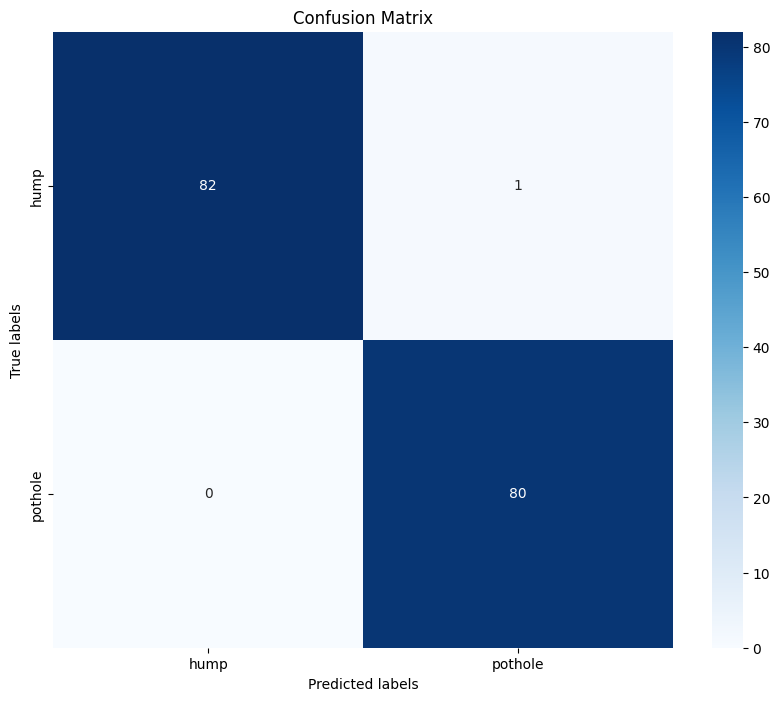

In [11]:
# Calculate the confusion matrix
cm = confusion_matrix(true_labels, predictions)

# Plot the confusion matrix
plt.figure(figsize=(10, 8))
sns.heatmap(cm, annot=True, fmt="d", cmap="Blues", xticklabels=classes, yticklabels=classes)
plt.xlabel('Predicted labels')
plt.ylabel('True labels')
plt.title('Confusion Matrix')
plt.show()

In [12]:
print(classification_report(true_labels, predictions))

              precision    recall  f1-score   support

           0       1.00      0.99      0.99        83
           1       0.99      1.00      0.99        80

    accuracy                           0.99       163
   macro avg       0.99      0.99      0.99       163
weighted avg       0.99      0.99      0.99       163



In [13]:
import torch.nn.functional as F

In [14]:
# Load and transform the image
image_path = '/kaggle/input/testingimage/testingimage/Image_6 (1).jpg'
image = Image.open(image_path)
input_image = data_transforms['test'](image).unsqueeze(0)

# Move the input image tensor to the same device as the model
input_image = input_image.to(device)

# Perform inference
model_ft.eval()
with torch.no_grad():
    output = model_ft(input_image)

# Apply softmax to obtain probabilities
probabilities = F.softmax(output, dim=1)

# Get the predicted class index
_, predicted = torch.max(output, 1)
predicted_class_index = predicted.item()

# Assuming you have a list of class names
# Replace with your class names
classes = ['hump', 'pothole']
predicted_label = classes[predicted_class_index]

# Get the probability of the predicted class
predicted_probability = probabilities[:, predicted_class_index].item()

print(f"Predicted class: {predicted_label}")
print(f"Probability: {predicted_probability}")
print(f"All probabilities: {probabilities.squeeze().tolist()}")

Predicted class: pothole
Probability: 0.9999932050704956
All probabilities: [6.822694103902904e-06, 0.9999932050704956]


In [15]:
# Load and transform the image
image_path = '/kaggle/input/testingimage/testingimage/Copy of IMG_20240229_080519.jpg'
image = Image.open(image_path)
input_image = data_transforms['test'](image).unsqueeze(0)

# Move the input image tensor to the same device as the model
input_image = input_image.to(device)

# Perform inference
model_ft.eval()
with torch.no_grad():
    output = model_ft(input_image)

# Apply softmax to obtain probabilities
probabilities = F.softmax(output, dim=1)

# Get the predicted class index
_, predicted = torch.max(output, 1)
predicted_class_index = predicted.item()

# Assuming you have a list of class names
# Replace with your class names
classes = ['hump', 'pothole']
predicted_label = classes[predicted_class_index]

# Get the probability of the predicted class
predicted_probability = probabilities[:, predicted_class_index].item()

print(f"Predicted class: {predicted_label}")
print(f"Probability: {predicted_probability}")
print(f"All probabilities: {probabilities.squeeze().tolist()}")

Predicted class: hump
Probability: 0.9666188955307007
All probabilities: [0.9666188955307007, 0.03338109329342842]
